# AUDIO PROJECT 3 - MUSIC SYNCHRONIZATION #
## 1. Description ##

## 2. Implementation ##
### 2.1 Initialization ###

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import librosa
import librosa.display
import sounddevice as sd

#### Load files and trim the silence part in each audio file

In [3]:
files = ["antti_yesterday.wav",
         "ferenc_yesterday.wav",
         "johanna_yesterday.wav",
         "outi_yesterday.wav"]
audio = []
fs = 0
hop_length = 1024
for f in files:
    signal,fs = librosa.load("../data/" + f)
    signal,index = librosa.effects.trim(signal)
    audio.append(signal)

In [4]:
len(audio[0])



378880

#### Overview on given signal ####

Playing antti_yesterday
Size: 378880
Playing ferenc_yesterday
Size: 433664
Playing johanna_yesterday
Size: 418304
Playing outi_yesterday
Size: 407040


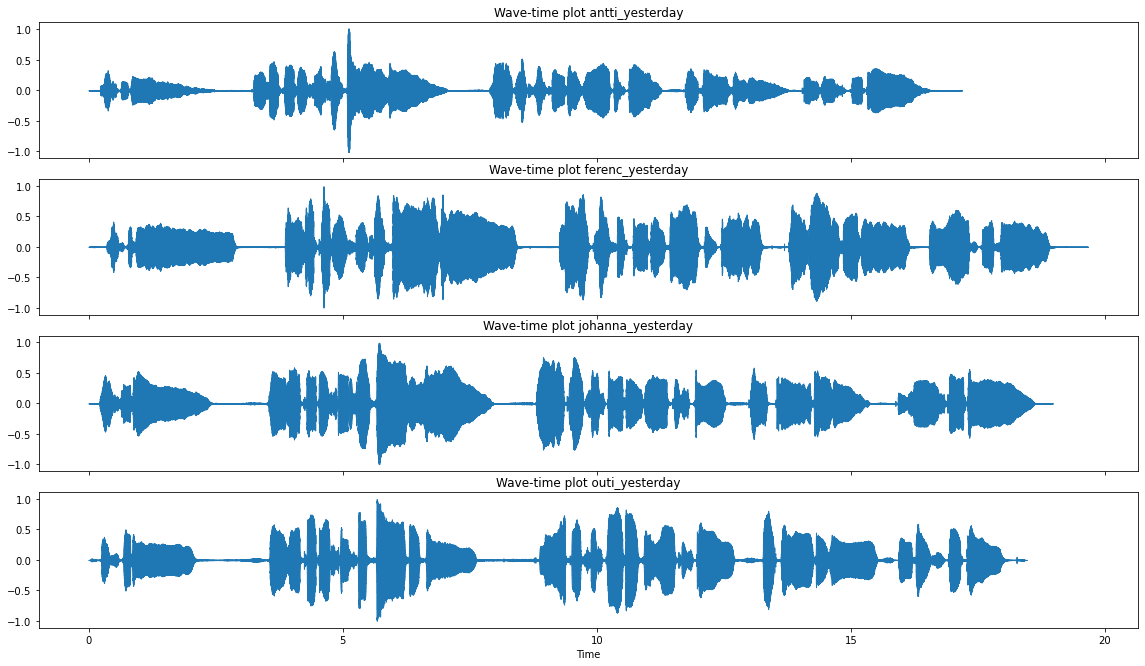

In [5]:
# Plot wave-time 4 signals - help function:
def plot_wave_time(signals,files,play_sound=False):
    fig, ax = plt.subplots(nrows=signals.__len__(),
                           sharex=True,
                           sharey=True,
                           figsize=(16,9))
    fig.tight_layout()
    for i,a in enumerate(signals):
        file_name = files[i].split('.')[0]
        print("Playing " + file_name)
        librosa.display.waveshow(a,sr=fs,ax=ax[i])
        ax[i].set(title="Wave-time plot " + file_name)
        ax[i].label_outer()
        if play_sound:
            sd.play(a,samplerate=fs,blocking="true")
        print("Size: " + str(a.size))

plot_wave_time(audio,files)

**Observation:**
- Audio signals have different lengths.
- The pattern in the audio signals (of the same music piece) are already recognizable.

**Decision**
- Time-stretch the last 3 signal based on the 1st <- DO WE NEED TO DO THIS STEP ?
- Stretch factor can be the ratio between signal's size


In [6]:
# stretched_signals = []
# for a in audio:
#     stretch_factor = a.size/audio[0].size
#     stretched_signal = librosa.effects.time_stretch(a,stretch_factor)
#     stretched_signals.append(stretched_signal)
# plot_wave_time(stretched_signals, files,play_sound=True)

**Comment:** The 3 later signals are shrinked down to the same size as the 1st signal, they
also heard a bit faster in pace.

### 2.2 Chroma features extract ###

In [7]:
# Help function to plot chroma presentation of signals
def plot_chroma(chroma,files):
    fig, ax = plt.subplots(nrows=chroma.__len__(),
                           sharex=True,
                           figsize=(16,9))
    fig.tight_layout()
    img = []
    for i,a in enumerate(chroma):
        file_name = files[i].split('.')[0]
        img = librosa.display.specshow(a,
                                 x_axis="time",
                                 y_axis="chroma",
                                 ax=ax[i])
        ax[i].set(title="Chroma representation of " + file_name)
        ax[i].label_outer()
    fig.colorbar(img,ax=ax)

### Chroma sequences alignment ###

0
1
2


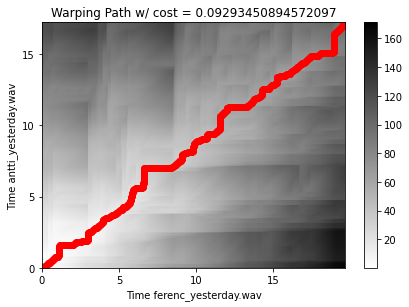

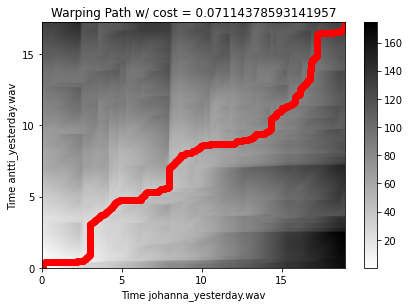

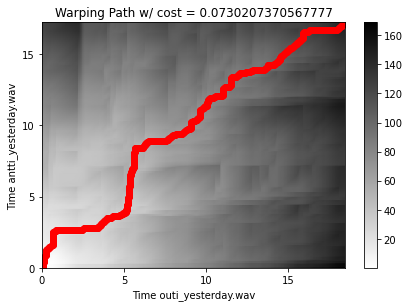

In [8]:
def plot_chroma_aligned(D,wp_s,cost,files):
    for i,file in enumerate(files[1:]):
        fig, ax = plt.subplots()
        fig.tight_layout()
        img = librosa.display.specshow(D[i], x_axis='time', y_axis='time', sr=fs,
                                       cmap='gray_r', hop_length=hop_length, ax=ax)
        print(i)
        ax.plot(wp_s[i][:, 1], wp_s[i][:, 0], marker='o', color='r')
        ax.set(title='Warping Path w/ cost = ' + str(cost[i]),
               xlabel='Time ' + files[i+1], ylabel='Time ' + files[0])
        fig.colorbar(img, ax=ax)

def perform_alignment(chroma, metric):
    cost = []
    D = []
    wp_s = []
    wp = []
    for i,c in enumerate(chroma[1:]):
        D_temp, wp_temp = librosa.sequence.dtw(X=chroma[0],Y=c,metric=metric)
        wp_s_temp = librosa.frames_to_time(wp_temp,sr=fs,hop_length=hop_length)
        D.append(D_temp)
        wp.append(wp_temp)
        wp_s.append(wp_s_temp)
        cost.append(D_temp[wp_temp[-1,0],wp_temp[-1,1]])
    return D,wp,wp_s,cost

chroma_cqt = []
for a in audio:
    chroma_cqt.append(librosa.feature.chroma_cqt(y=a,
                                             hop_length=hop_length,
                                             sr=fs,
                                             tuning=0,
                                             norm=2))

D, wp, wp_s, cost = perform_alignment(chroma_cqt,metric='cosine')
plot_chroma_aligned(D,wp_s, cost,files)

In [9]:
# N = 4410
# chroma_stft = []
# for a in audio:
#     chroma_stft.append(librosa.feature.chroma_stft(y=a,
#                                              hop_length=hop_length,
#                                              tuning=0,
#                                              sr=fs,
#                                              norm=2,
#                                              n_fft=N))
#
# D,wp, wp_s, cost = perform_alignment(chroma_stft,metric='cosine')
# plot_chroma_aligned(D,wp_s, cost,files)

### 2.3 Evaluate ###


In [43]:
coord_antti = [[], [], []]
coord_other = [[], [], []]

0
1
2


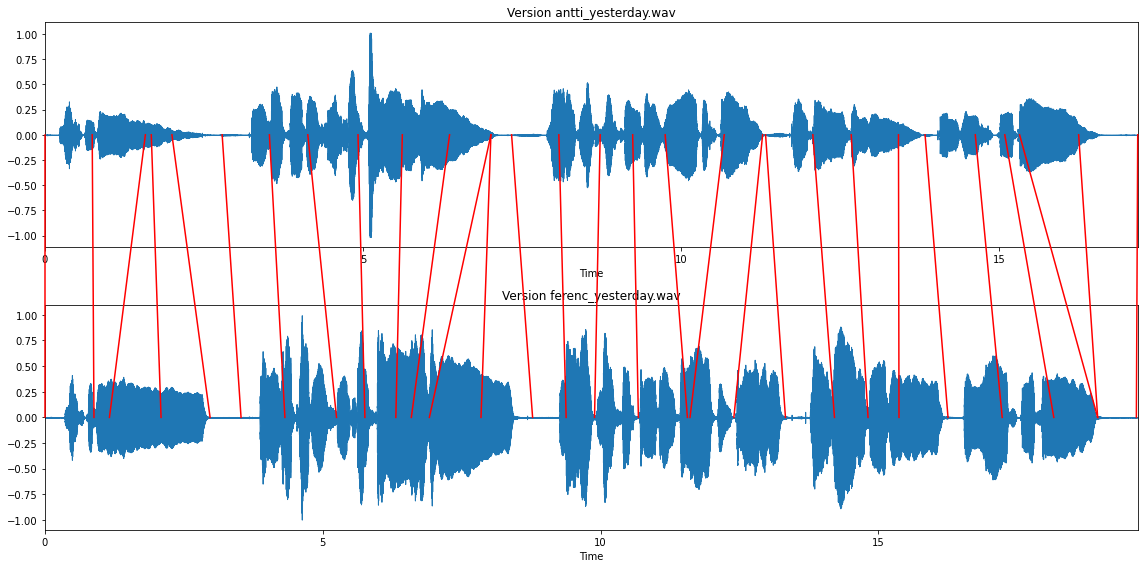

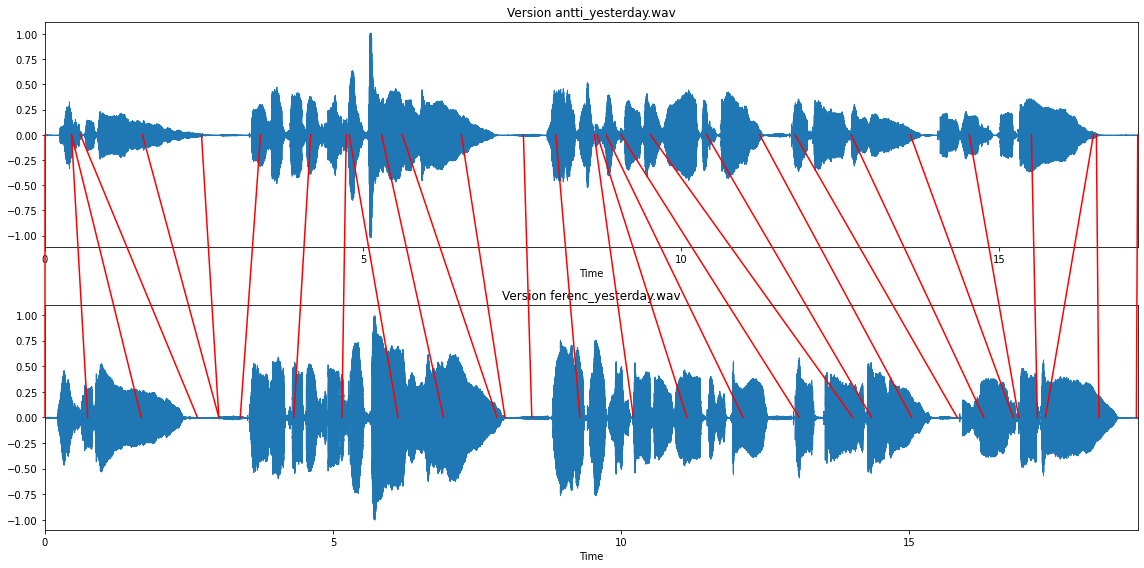

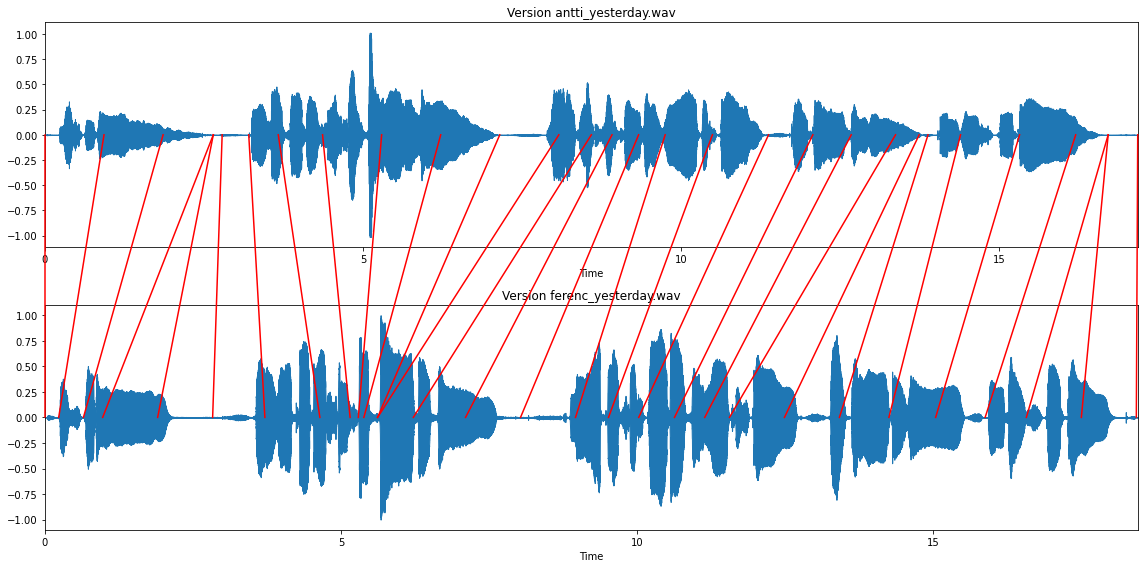

In [44]:
for i,a in enumerate(audio[1:]):
    print(i)
    # Plot audio1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
    librosa.display.waveplot(audio[0], sr=fs, ax=ax1)
    ax1.set(title='Version '+str(files[0]))

    # Plot audio2
    librosa.display.waveplot(audio[i+1], sr=fs, ax=ax2)
    ax2.set(title='Version '+str(files[1]))
    plt.tight_layout()
    
    trans_figure = fig.transFigure.inverted()
    lines = []
    arrows = 30
    points_idx = np.int16(np.round(np.linspace(0, wp[i].shape[0] - 1, arrows)))
    
    for tp1, tp2 in wp[i][points_idx] * hop_length / fs:
        # get position on axis for a given index-pair
        #print([tp1, 0],[tp2, 0]) #same points 

        coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
        coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))
        coord_antti[i].insert(0, tp1)  
        coord_other[i].insert(0, tp2)

        # draw a line
        line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                       (coord1[1], coord2[1]),
                                       transform=fig.transFigure,
                                       color='r')
        lines.append(line)

    fig.lines = lines
    plt.tight_layout()


In [48]:
print(len(coord_antti[0]), len(coord_other[0]))

print(coord_antti[0][2], coord_other[0][2])
print(coord_antti[0][12], coord_antti[0][12])

30 30
1.5789569160997732 1.1609977324263039
7.012426303854875 7.012426303854875


In [51]:
for i,a in enumerate(audio[1:]):
    for j in range(0,20):
        sd.play(audio[0][int(coord_antti[i][j]*fs):int(coord_antti[i][j]*fs)+20000:],samplerate=fs,blocking="false")
        sd.play(audio[i+1][int(coord_other[i][j]*fs):int(coord_other[i][j]*fs)+20000:],samplerate=fs,blocking="false")
        

In [ ]:
#Observation
# There is 30 checkpoint for each file for syncing 
# File 1 and file 2  seems to match 99% time 
# However file1 and file 2 , file1 and file3 seems bit off (we need to find reasons for this and add to report)
# File 3 and file 4 are syncing better than file1 and file 2
